### 개선방향
- 모델을 Simple CNN에서 Deep CNN으로 변경
- 데이터 증강 항목 추가

### 00. 사용 모듈

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

### 01. 데이터셋 만들기

In [3]:
image_dir = "./lumbar_spinal_dataset"

In [ ]:
batch_size = 16
img_height = 224
img_width = 224

In [5]:
train_dir = "./lumbar_spinal_dataset/training"
test_dir = "./lumbar_spinal_dataset/testing"

In [6]:
# 데이터 세트 만들기

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = (img_height, img_width),
    batch_size = batch_size
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

print(train_ds.class_names)
print(val_ds.class_names)

Found 4808 files belonging to 3 classes.
Found 1158 files belonging to 3 classes.
['Herniated Disc', 'No Stenosis', 'Thecal Sac']
['Herniated Disc', 'No Stenosis', 'Thecal Sac']


In [17]:
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

NUM_CLASSES = 3  # 실제 클래스 개수로 설정

# 1) 라벨 뽑기 (one-hot → 정수 ID 가정)
y_train = []
for _, labels in train_ds.unbatch():
    # labels가 one-hot이면 argmax, 정수라벨이면 int(labels.numpy())
    if len(labels.shape) > 0 and labels.shape[-1] == NUM_CLASSES:   # one-hot
        y_train.append(int(np.argmax(labels.numpy())))
    else:                                                           # 정수 라벨
        y_train.append(int(labels.numpy()))
y_train = np.array(y_train, dtype=np.int64)

# 2) 분포 확인 (int로 캐스팅된 dict)
counts = Counter(y_train.tolist())
counts = {int(k): int(v) for k, v in counts.items()}
print("클래스별 분포:", counts)

# 3) 누락된 클래스가 있으면 0으로 채워 넣기 (안전)
for c in range(NUM_CLASSES):
    counts.setdefault(c, 0)

# 4) sklearn으로 class_weight 계산
classes = np.array(sorted(counts.keys()))
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("class_weight:", class_weight_dict)


클래스별 분포: {1: 1542, 0: 1903, 2: 1363}
class_weight: {0: 0.8421790155894202, 1: 1.0393428447903157, 2: 1.1758376131083395}


- 데이터 시각화하기

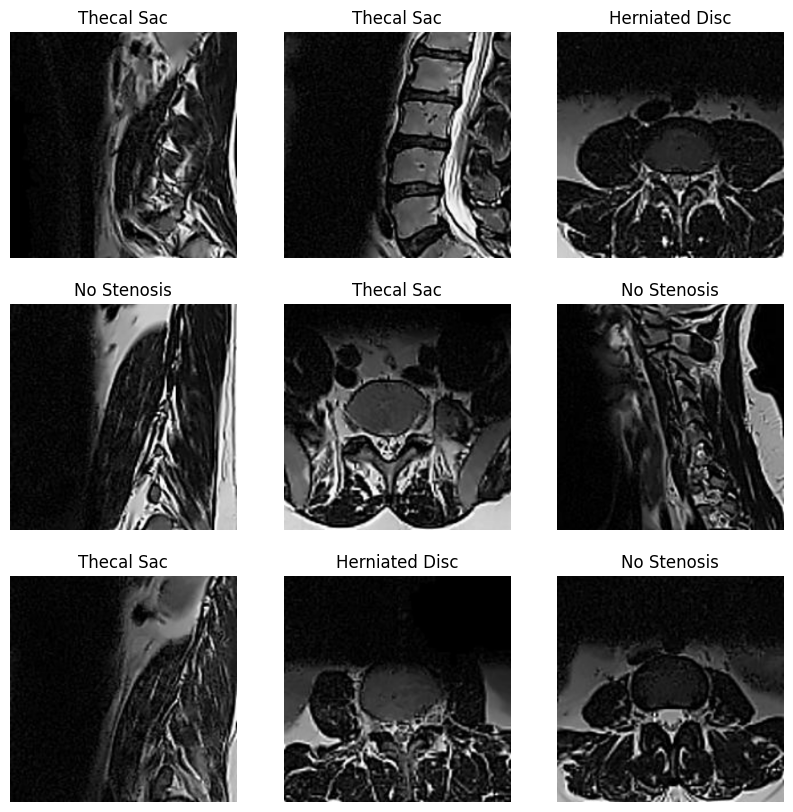

In [8]:
# 데이터 시각화하기
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9) : 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off") # 축 표시 없애기 

In [9]:
# 이미지 shape 확인 (batch_size = 32, image_size = 224 * 224, layer = 3(RGB))
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break # 한 loop만 출력하고 빠져나오기 

(16, 256, 256, 3)
(16,)


In [8]:
# 데이터 표준화하기 (방법 1)
# RGB의 값 : [0 ~ 225] 범위 -> 신경망에 들어가기엔 너무 큼 -> 입력 값 작게 하기 

normalization_layer = tf.keras.layers.Rescaling(1./225) # [0 ~ 1] 범위로 표준화하기 

In [9]:
# 데이터 표준화하기 (방법 2)
# dataset.map 호출하기 
normalized_ds = train_ds.map(lambda x, y : (normalization_layer(x), y)) 
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) # 픽셀 values -> 0 ~ 1 사이로 평균화됨. 

0.0 1.1333333


In [12]:
# 데이터 미세 조정
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 02. 데이터 증강하기 

In [10]:
data_augment = keras.Sequential([
    layers.RandomRotation(0.04),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name = 'augment')

### 03. 모델 생성하기

In [11]:
print(train_ds.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


- 헤드만 학습하기

In [20]:
# 모델: EfficientNetB0 백본 + 분류기
num_classes = 3

# 백본: EfficientNetB0
base = keras.applications.ResNet50(
    include_top = False, weights = "imagenet",
    input_shape = (img_height, img_width, 3)
)

# 백본 동결
base.trainable = False

# 분류기 헤드 정의하기
inputs = keras.Input(shape = (img_height, img_width, 3))
x = keras.applications.efficientnet.preprocess_input(inputs)   # EfficientNet 전처리
x = base(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# 클래스 가중치
class_weight = {0: 0.842, 1: 1.039, 2: 1.176}

# optimizer, loss, metric
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-4),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

# 콜백
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', mode = 'max', patience = 2, factor = 0.5, min_lr = 1e-7),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]

# 헤드만 학습
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight,
    callbacks=callbacks
)

# 8) 2단계: Progressive unfreezing (상위 블록만 풀기)
base.trainable = True
for layer in base.layers[:-20]:   # 하위 대부분은 고정, 상위 20개 레이어만 풀기
    layer.trainable = False


Epoch 1/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 206s 660ms/step - accuracy: 0.3347 - loss: 1.6761 - val_accuracy: 0.2496 - val_loss: 1.3450 - learning_rate: 1.0000e-04
Epoch 2/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 236s 783ms/step - accuracy: 0.3646 - loss: 1.4838 - val_accuracy: 0.2556 - val_loss: 1.3033 - learning_rate: 1.0000e-04
Epoch 3/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.3713 - loss: 1.4146 - val_accuracy: 0.2737 - val_loss: 1.2734 - learning_rate: 1.0000e-04
Epoch 4/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - accuracy: 0.3981 - loss: 1.2898 - val_accuracy: 0.3316 - val_loss: 1.1951 - learning_rate: 1.0000e-04
Epoch 5/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.4052 - loss: 1.2541 - val_accuracy: 0.3342 - val_loss: 1.2226 - learning_rate: 1.0000e-04


### 04. 모델 훈련하기

In [22]:
# Optimizer 재설정: backbone은 더 작은 LR
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# 8) 전체 학습 (num_epochs_total=25)
history_total = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=history_head.epoch[-1] + 1,
    epochs=25,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 6/25


301/301 ━━━━━━━━━━━━━━━━━━━━ 271s 866ms/step - accuracy: 0.4257 - loss: 1.1635 - val_accuracy: 0.3826 - val_loss: 1.1975 - learning_rate: 1.0000e-05
Epoch 7/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 249s 827ms/step - accuracy: 0.5056 - loss: 1.0147 - val_accuracy: 0.4016 - val_loss: 1.1827 - learning_rate: 1.0000e-05
Epoch 8/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 248s 779ms/step - accuracy: 0.5822 - loss: 0.8829 - val_accuracy: 0.4136 - val_loss: 1.2164 - learning_rate: 1.0000e-05
Epoch 9/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.6593 - loss: 0.7656 - val_accuracy: 0.4059 - val_loss: 1.2872 - learning_rate: 1.0000e-05
Epoch 10/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 262s 780ms/step - accuracy: 0.7153 - loss: 0.6630 - val_accuracy: 0.4119 - val_loss: 1.3683 - learning_rate: 1.0000e-05
Epoch 11/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.7752 - loss: 0.5415 - val_accuracy: 0.4257 - val_loss: 1.3499 - learning_rate: 5.0000e-06
Epoch 12/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step -

### 05. 결과 출력하기

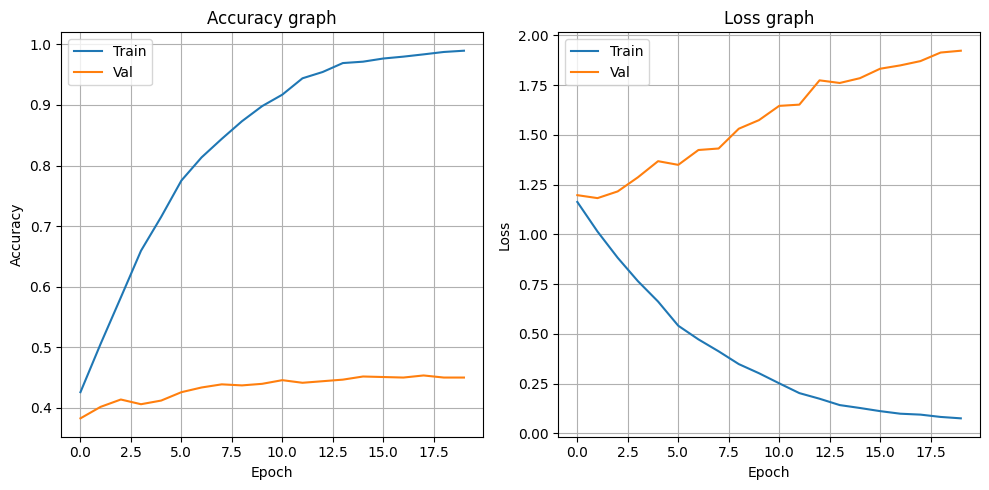

In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history_total.history['accuracy'], label='Train')
ax1.plot(history_total.history['val_accuracy'], label='Val')
ax1.set_title('Accuracy graph')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid()

ax2.plot(history_total.history['loss'], label='Train')
ax2.plot(history_total.history['val_loss'], label='Val')
ax2.set_title('Loss graph')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

- Confusion Matrix

In [29]:
# 한글폰트 적용
plt.rc('font', family='Malgun gothic')
plt.rcParams['axes.unicode_minus'] =False

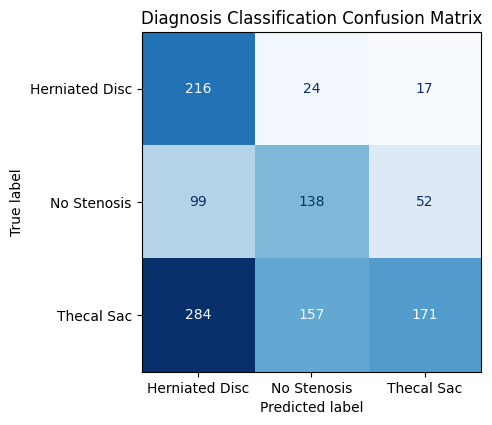

In [28]:
# confusion matrix
true_labels = []
pred_labels  = []

for images, labels in val_ds:  # 각 배치 순회
    # 추론
    outputs = model(images, training=False)

    # (1) 모델이 '분류 로짓'만 단일 출력인 경우
    logits = outputs

    # (2) 모델이 '회귀 + 분류' 같이 다중 출력인 경우 (예: (t_score, class_logits))
    #if isinstance(outputs, (list, tuple)):
    #    # 회귀 출력이 먼저고, 분류 출력이 뒤라고 가정 (필요시 순서 바꾸세요)
    #    _, logits = outputs
    #else:
    #    logits = outputs

    # 소프트맥스 전 로짓이어도 argmax로 예측 클래스 추출 가능
    preds = tf.argmax(logits, axis=1)

    true_labels.append(labels.numpy())
        pred_labels.append(preds.numpy())

    true_labels = np.concatenate(true_labels, axis=0)
    pred_labels = np.concatenate(pred_labels, axis=0)

    class_names = getattr(val_ds, "class_names", None)
    if class_names is None:
        class_names = ['Herniated Disc', 'No Stenosis', 'Thecal Sac'] 

    # 혼동행렬 계산 & 시각화
    cm = confusion_matrix(true_labels, pred_labels)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
    ax.set_title("증상 분류 혼동 행렬")

    plt.tight_layout()
    plt.show()